In [1]:
import re
import requests
import pandas as pd
from bs4 import BeautifulSoup
import concurrent.futures


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)



## Get the list of companies in the S&P 500 

In [2]:
# URL of the S&P 500 Wikipedia page
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

# Define headers to mimic a browser request
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}

# Send a GET request to the URL and store the response
response = requests.get(url, headers=headers)

# Check if the request was successful
if response.status_code == 200:
    # Parse the HTML content of the response using BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find the table that contains the S&P 500 list using Pandas
    tables = pd.read_html(str(soup))

    # Check if any tables were found
    if len(tables) > 0:
        # The first table in the list should be the S&P 500 table
        sp500_table = tables[0]

        # Extract the company names from the table
        companies = sp500_table['Security'].tolist()

    else:
        print("Error: Could not find table")

else:
    print(f"Error: Request failed with status code {response.status_code}")


sp500_table.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [3]:
# wrtte the table of the S&P 500
sp500_table.to_csv(r'./data/snp.csv', index=False)


## Get the Top Institutional Holders for any stock

In [20]:
def get_shareholders(stock_symbol):
    url = f"https://money.cnn.com/quote/shareholders/shareholders.html?symb={stock_symbol}&subView=institutional"
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        # Parse the HTML using BeautifulSoup
        soup = BeautifulSoup(response.text, 'html5lib')

        # Get the table titles from the HTML
        table_titles = ['Top 10 Owners', 'Top 10 Mutual Funds']

        # Parse the tables using Pandas
        tables = pd.read_html(response.text)[4:]

        # Create a dictionary to store the dataframes with their titles
        dataframes = {}

        # Iterate through the tables and save them as separate dataframes with their titles
        for index, table in enumerate(tables):
            # Add the stock_symbol column to the table
            table['Symbol'] = stock_symbol

            # Save the table as a dataframe in the dictionary with the title as the key
            dataframes[table_titles[index]] = table

        return dataframes

    else:
        print(f"Error: Request failed for {stock_symbol} with status code {response.status_code}")
        return None

In [22]:
# Example usage
stock_symbol = "AZO"  # Replace with the stock symbol you want to check
top_shareholders = get_shareholders(stock_symbol)
top_shareholders['Top 10 Owners']

,Stockholder,Stake,Sharesowned,Total value ($),Sharesbought / sold,Totalchange,Symbol
0,"The Vanguard Group, Inc.",9.61%,1767386,4344499896,-35769,-1.98%,AZO
1,BlackRock Fund Advisors,6.04%,1110776,2730454024,23045,+2.12%,AZO
2,"JPMorgan Investment Management, I...",5.90%,1085747,2668928988,61256,+5.98%,AZO
3,Fidelity Management & Research Co...,5.36%,986454,2424851900,8246,+0.84%,AZO
4,"SSgA Funds Management, Inc.",4.38%,806627,1982810160,-26456,-3.18%,AZO
5,Fiera Capital Corp. (Investment M...,3.15%,578561,1422189722,-61310,-9.58%,AZO
6,"Boston Partners Global Investors,...",2.88%,528970,1300287606,-98165,-15.65%,AZO
7,Geode Capital Management LLC,2.44%,449858,1105818443,-5517,-1.21%,AZO
8,RBC Global Asset Management (UK) ...,1.81%,333019,818610655,-10870,-3.16%,AZO
9,Norges Bank Investment Management,1.45%,267129,656643151,66737,+33.30%,AZO


In [23]:

sp500_top_holders = []
sp500_top_mutual_fund_holders = []


# define a function to call get_shareholders() for a single symbol
def process_stock(symbol):
    try:
        # call the get_shareholders() function and return the resulting DataFrame
        return get_shareholders(symbol)
    except:
        # if an exception is raised, return None
        print(f"Error processing {symbol}, skipping...")
        return None
    
# create a ThreadPoolExecutor with 100 worker threads
with concurrent.futures.ThreadPoolExecutor(max_workers=20) as executor:
    # submit a process_stock task for each symbol in sp500_table, and store the Future object for each task in a list
    futures = [executor.submit(process_stock, symbol) for symbol in sp500_table['Symbol']]
    # iterate over the Futures and get the result for each one (if available), and append it to the dfs list
    for future in concurrent.futures.as_completed(futures):
        result = future.result()
        if result is not None:
            for key,value in result.items():
                if key == 'Top 10 Owners':
                    sp500_top_holders.append(value)

                if key == 'Top 10 Mutual Funds':
                    sp500_top_mutual_fund_holders.append(value)

    
# concatenate the DataFrames in the list into a new DataFrame
sp500_top_holders_table = pd.concat(sp500_top_holders).reset_index(drop=True)
sp500_top_mutual_fund_holderss_table = pd.concat(sp500_top_mutual_fund_holders).reset_index(drop=True)

In [28]:
print(len(sp500_top_holders_table))
print(len(sp500_top_mutual_fund_holderss_table))

5010
5010


In [30]:
# wrtte the table of the S&P 500 top shareholders 
sp500_top_holders_table.to_csv(r'./data/snp_top_shareholders.csv', index=False)
sp500_top_mutual_fund_holderss_table.to_csv(r'./data/snp_top_mutual_fund_shareholders.csv', index=False)

In [31]:
sp500_top_holders_table.columns

Index(['Stockholder', 'Stake', 'Sharesowned', 'Total value ($)',
       'Sharesbought / sold', 'Totalchange', 'Symbol'],
      dtype='object')

In [13]:
sp500_table.columns

Index(['Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry',
       'Headquarters Location', 'Date added', 'CIK', 'Founded'],
      dtype='object')

## Plots data

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [4]:
sp500_top_holders_table = pd.read_csv(r'./data/snp_top_shareholders.csv')
sp500_table = pd.read_csv(r'./data/snp.csv')

In [33]:
len(sp500_top_holders_table['Stockholder'].unique())

282

In [58]:
print("\n".join(list(sp500_top_holders_table['Stockholder'].unique())) )

The Vanguard Group, Inc.
BlackRock Fund Advisors
SSgA Funds Management, Inc.
Fidelity Management & Research Co...
Geode Capital Management LLC
PRIMECAP Management Co.
Polen Capital Management LLC
Massachusetts Financial Services ...
Norges Bank Investment Management
Fisher Asset Management LLC
Edgewood Management LLC
Sands Capital Management LLC
Wellington Management Co. LLP
Capital Research & Management Co....
T. Rowe Price Associates, Inc. (I...
State Farm Investment Management ...
Northern Trust Investments, Inc.(...
APG Asset Management NV
Boston Partners Global Investors,...
Kayne Anderson Rudnick Investment...
Pictet Asset Management SA
AKO Capital LLP
Ninety One UK Ltd.
Baillie Gifford & Co.
Franklin Advisers, Inc.
T. Rowe Price Investment Manageme...
BlackRock Investment Management (...
Canada Pension Plan Investment Bo...
Nordea Investment Management AB (...
Amundi Asset Management US, Inc.
Bank of America, NA (Private Bank...
First Trust Advisors LP
AllianceBernstein LP
Berks

## Bar Chart of the GICS Sectors in the S&P 500

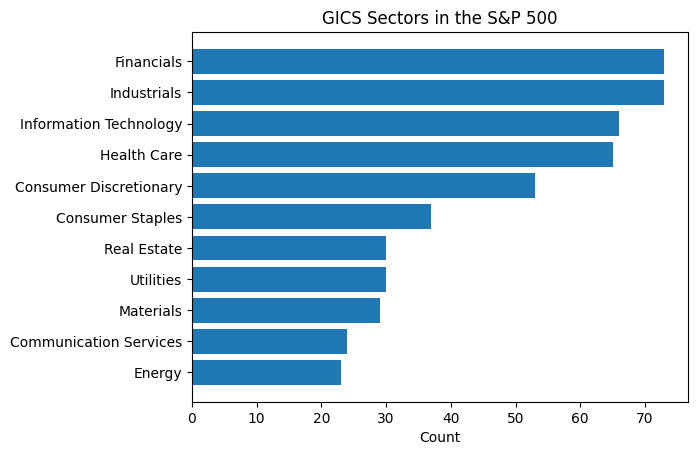

In [64]:
# Create a new dataframe with the count of stocks in each GICS Sector
sector_count = sp500_table.groupby('GICS Sector')['Symbol'].count().reset_index()
sector_count = sector_count.rename(columns={'Symbol': 'Count'})

# Sort the dataframe by Count in descending order
sector_count = sector_count.sort_values('Count', ascending=False)

# Plot the top 10 GICS Sectors
plt.barh(sector_count['GICS Sector'], sector_count['Count'])
plt.gca().invert_yaxis() # Invert the y-axis so that the top sector is at the top
plt.title('GICS Sectors in the S&P 500')
plt.xlabel('Count')
plt.show()

## Scatter Plot of Total Value vs. Shares Owned

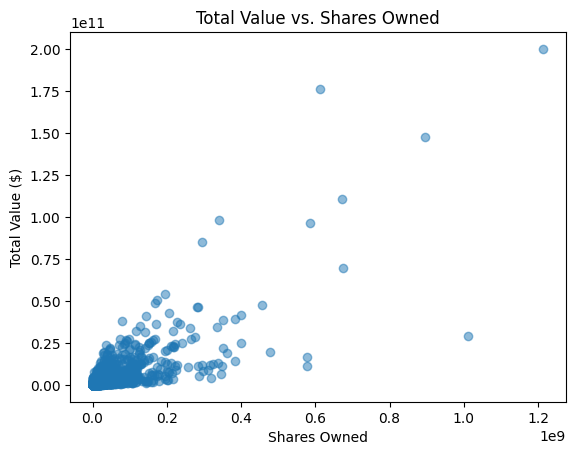

In [37]:
# Merge the two dataframes on the 'Symbol' column
merged_df = pd.merge(sp500_top_holders_table, sp500_table, on='Symbol')

# Plot a scatter plot of Total value vs. Shares owned
plt.scatter(merged_df['Sharesowned'], merged_df['Total value ($)'], alpha=0.5)
plt.title('Total Value vs. Shares Owned')
plt.xlabel('Shares Owned')
plt.ylabel('Total Value ($)')
plt.show()

## Stacked Bar Chart of Top 10 Stockholders in Each GICS Sector

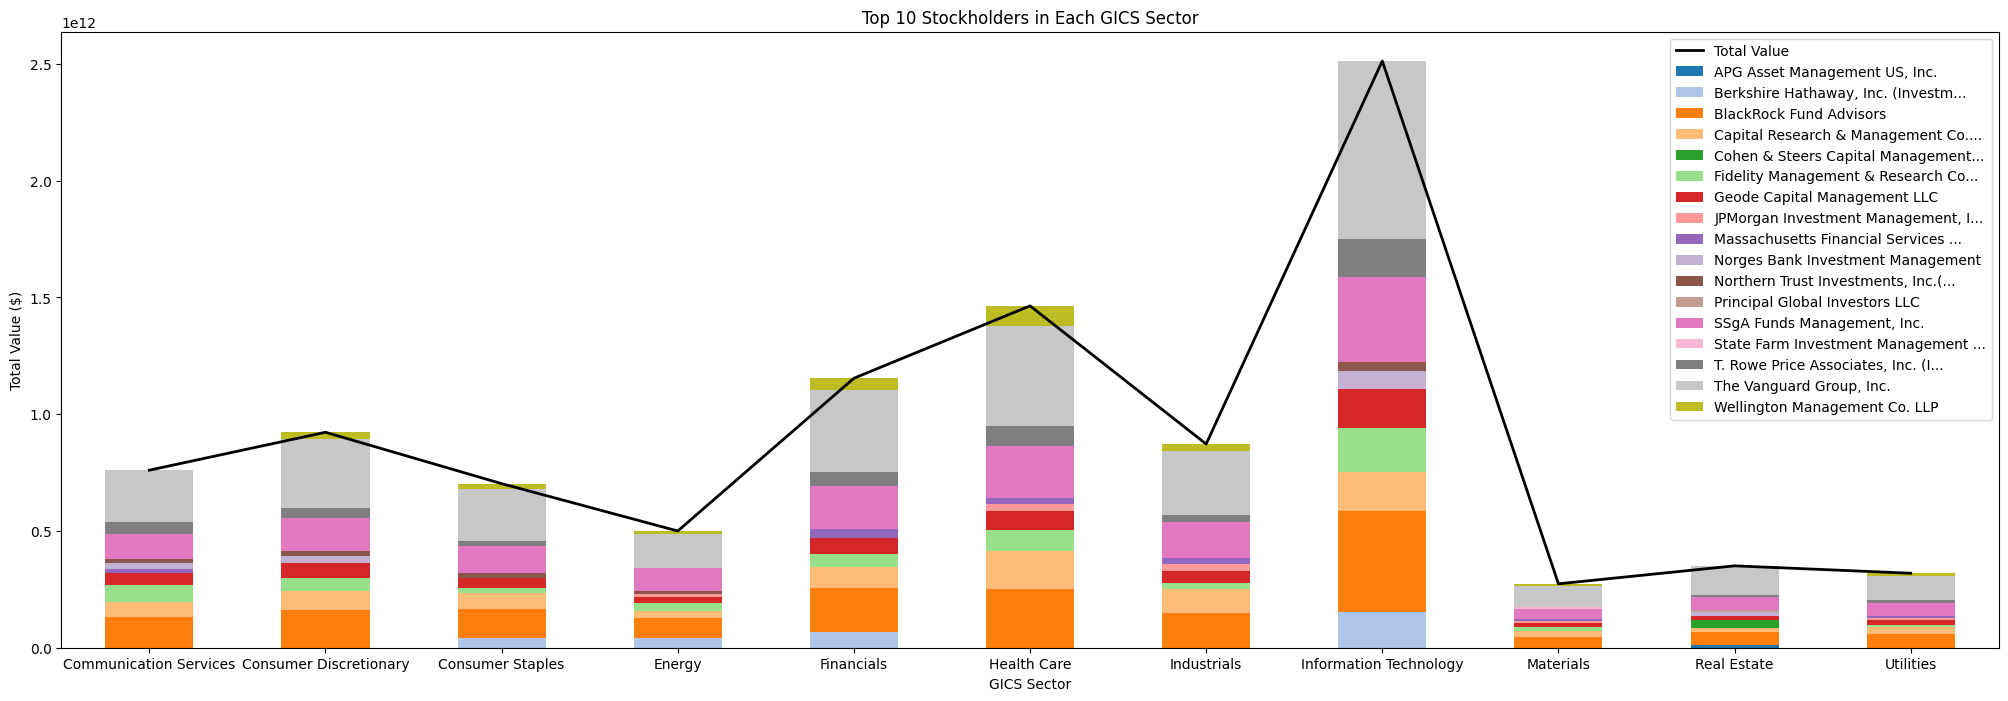

In [80]:
# Merge the two dataframes on the 'Symbol' column
merged_df = pd.merge(sp500_top_holders_table, sp500_table, on='Symbol')


# Pivot the merged dataframe to get the top 10 stockholders in each GICS Sector
top_10_stockholders = pd.pivot_table(merged_df, index=['GICS Sector', 'Stockholder'], values=['Total value ($)'], aggfunc='sum')
top_10_stockholders = top_10_stockholders.sort_values(['GICS Sector', 'Total value ($)'], ascending=[True, False])
top_10_stockholders = top_10_stockholders.groupby('GICS Sector').head(10)

# Reset the index and rename columns
top_10_stockholders = top_10_stockholders.reset_index()
top_10_stockholders = top_10_stockholders.rename(columns={'Total value ($)': 'Total Value'})

# Pivot again to get the total value of the top 10 stockholders in each GICS Sector
sector_totals = pd.pivot_table(top_10_stockholders, index='GICS Sector', values='Total Value', aggfunc='sum')

# Set the figure size
fig, ax = plt.subplots(figsize=(25, 8))

# Color palette with 10 distinct colors
colors = sns.color_palette('tab20', n_colors=len(top_10_stockholders))

# Create a stacked bar chart of the top 10 stockholders in each GICS Sector
top_10_stockholders = top_10_stockholders.groupby(['GICS Sector', 'Stockholder'])['Total Value'].sum().unstack()
top_10_stockholders.plot(kind='bar', stacked=True, ax=ax, color=colors)
sector_totals.plot(kind='line', color='black', linewidth=2, label='Total', ax=ax)

plt.title('Top 10 Stockholders in Each GICS Sector')
plt.xlabel('GICS Sector')
plt.ylabel('Total Value ($)')
plt.legend()


plt.savefig(r'img/top_10_stockholders.png', dpi=300, bbox_inches='tight')

plt.show()




In [41]:
## Bar Chart of the Top 10 Owners of the  S&P 500

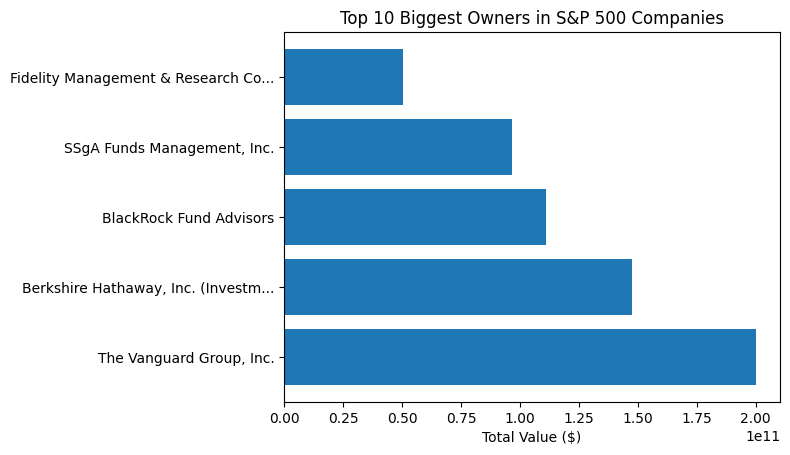

In [52]:
# Sort the dataframe by 'Total value ($)' in descending order
sp500_top_holders_sorted = sp500_top_holders_table.sort_values(by='Total value ($)', ascending=False)

# Select the top 10 biggest owners
top_10_biggest_owners = sp500_top_holders_sorted.head(10)

# Create a horizontal bar chart of the top 10 biggest owners
plt.barh(top_10_biggest_owners['Stockholder'], top_10_biggest_owners['Total value ($)'])
plt.title('Top 10 Biggest Owners in S&P 500 Companies')
plt.xlabel('Total Value ($)')
plt.show()

In [62]:
# Filter the sp500_top_holders_table by the stockholder name and the top owner stake
vanguard_top_holdings = sp500_top_holders_table[(sp500_top_holders_table['Stockholder'].str.contains('The Vanguard Group, Inc')) & (sp500_top_holders_table['Sharesowned'] == sp500_top_holders_table['Sharesowned'].max())]

# Merge the vanguard_top_holdings dataframe with the sp500_table dataframe to get the company names
vanguard_top_holdings = pd.merge(vanguard_top_holdings, sp500_table[['Symbol', 'Security']], on='Symbol', how='left')

# Print the list of companies
print(vanguard_top_holdings['Security'])

0    Apple Inc.
Name: Security, dtype: object
